[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/pymc4/scripts/interactive/example_what_if.ipynb)

In [1]:
#optional (if not cloned i.e. running in colab)
# !pip install covid19_inference



# Example: What-if scenarios
Create different scenarios on what may be the effect of a (future) change point
Non-hierarchical model using jhu data (no regions).

Runtime ~ 15 min

At the end we also show how to plot with German labels.


In [2]:
import datetime
import copy
import sys

In [3]:
import pymc as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

In [5]:
# limit the data range
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 5, 14)

In [6]:
# download data
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Germany", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Germany", data_begin=bd, data_end=ed)

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


In [7]:
# set model parameters
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=28,
    diff_data_sim=16,
    N_population=83e6,
)

In [8]:
# change points like in the paper
cp_base = [
    # mild distancing
    dict(
        # account for new implementation where transients_day is centered, not begin
        pr_mean_date_transient=datetime.datetime(2020, 3, 10),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
    ),
    # strong distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 17),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
    ),
    # contact ban
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 24),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=0.5,
    ),
]



Scenarios for May 11, due to ~11 days delay, not evident in data yet
Add additional change points with reference to the previous values.

We use a value as reference that we inferred in a previous run (as of May 14)

In [9]:
ref = 0.10
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [10]:
# a: double the contacts (this only effectively applies apart from family)
cp_a = copy.deepcopy(cp_base)
cp_a.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref * 2,
        pr_sigma_lambda=0.3,
    )
)

In [11]:
# b: back to pre-lockdown value
cp_b = copy.deepcopy(cp_base)
cp_b.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=0.15,
        pr_sigma_lambda=0.3,
    )
)

In [12]:
# c: 20% decrease, ideal case, for instance if contact tracing is very effective
cp_c = copy.deepcopy(cp_base)
cp_c.append(
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 5, 12),
        pr_sigma_date_transient=1,
        pr_median_lambda=ref - ref * 0.2,
        pr_sigma_lambda=0.3,
    )
)

In [13]:
# we want to create multiple models with the different change points
def create_model(change_points, params_model):
    with cov19.Cov19Model(**params_model) as this_model:
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
            name_lambda_t="lambda_t",
        )
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu)
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )
        new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")
        cov19.model.student_t_likelihood(cases=new_cases)
    return this_model

In [14]:
mod_a = create_model(cp_a, params_model)
mod_b = create_model(cp_b, params_model)
mod_c = create_model(cp_c, params_model)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 1
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [co


## engage!
Increase tune and/or draws to get better statistics.


In [15]:
tr_a = pm.sample(model=mod_a, tune=200, draws=200, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b, tune=200, draws=200, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c, tune=200, draws=200, init="advi+adapt_diag")

Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18100
INFO     [pymc.variational.inference] Convergence achieved at 18100
Interrupted at 18,099 [9%]: Average Loss = 833.58
INFO     [pymc.variational.inference] Interrupted at 18,099 [9%]: Average Loss = 833.58
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 577 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 577 seconds.
Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17900
INFO     [pymc.variational.inference] Convergence achieved at 17900
Interrupted at 17,899 [8%]: Average Loss = 836.83
INFO     [pymc.variational.inference] Interrupted at 17,899 [8%]: Average Loss = 836.83
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 429 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 429 seconds.
Only 200 samples in chain.
WARNING  [pymc] Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 19700
INFO     [pymc.variational.inference] Convergence achieved at 19700
Interrupted at 19,699 [9%]: Average Loss = 818.91
INFO     [pymc.variational.inference] Interrupted at 19,699 [9%]: Average Loss = 818.91
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, lambda_4_log_, transient_day_1, transient_day_2, transient_day_3, transient_day_4, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, transient_len_4_raw_, mu, I_begin, delay_log, weekend_factor_log, offset_modulation_rad, sigma_obs]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 591 seconds.
INFO     [pymc] Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 591 seconds.
The acceptance probability does not match the target. It is 0.8923, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc] The acceptance probability does not match the target. It is 0.8923, but should be close to 0.8. Try to increase the number of tuning steps.


## Plotting

In [76]:
%%capture
fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=cum_cases[0],
    forecast_label="Pessimistic",
    forecast_heading=r"$\bf Scenarios\!:$",
    add_more_later=True,
    color="tab:red",
)
axes[1].set_ylim(0,8000)

In [38]:
fig, axes = cov19.plot.timeseries_overview(
    mod_b,
    tr_b,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Neutral",
    color="tab:orange",
)

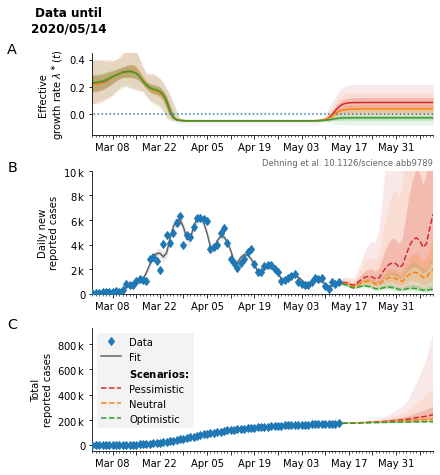

In [39]:
fig, axes = cov19.plot.timeseries_overview(
    mod_c,
    tr_c,
    axes=axes,
    offset=cum_cases[0],
    forecast_label="Optimistic",
    color="tab:green",
)
fig